/tmp/ipykernel_1199919/305597426.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


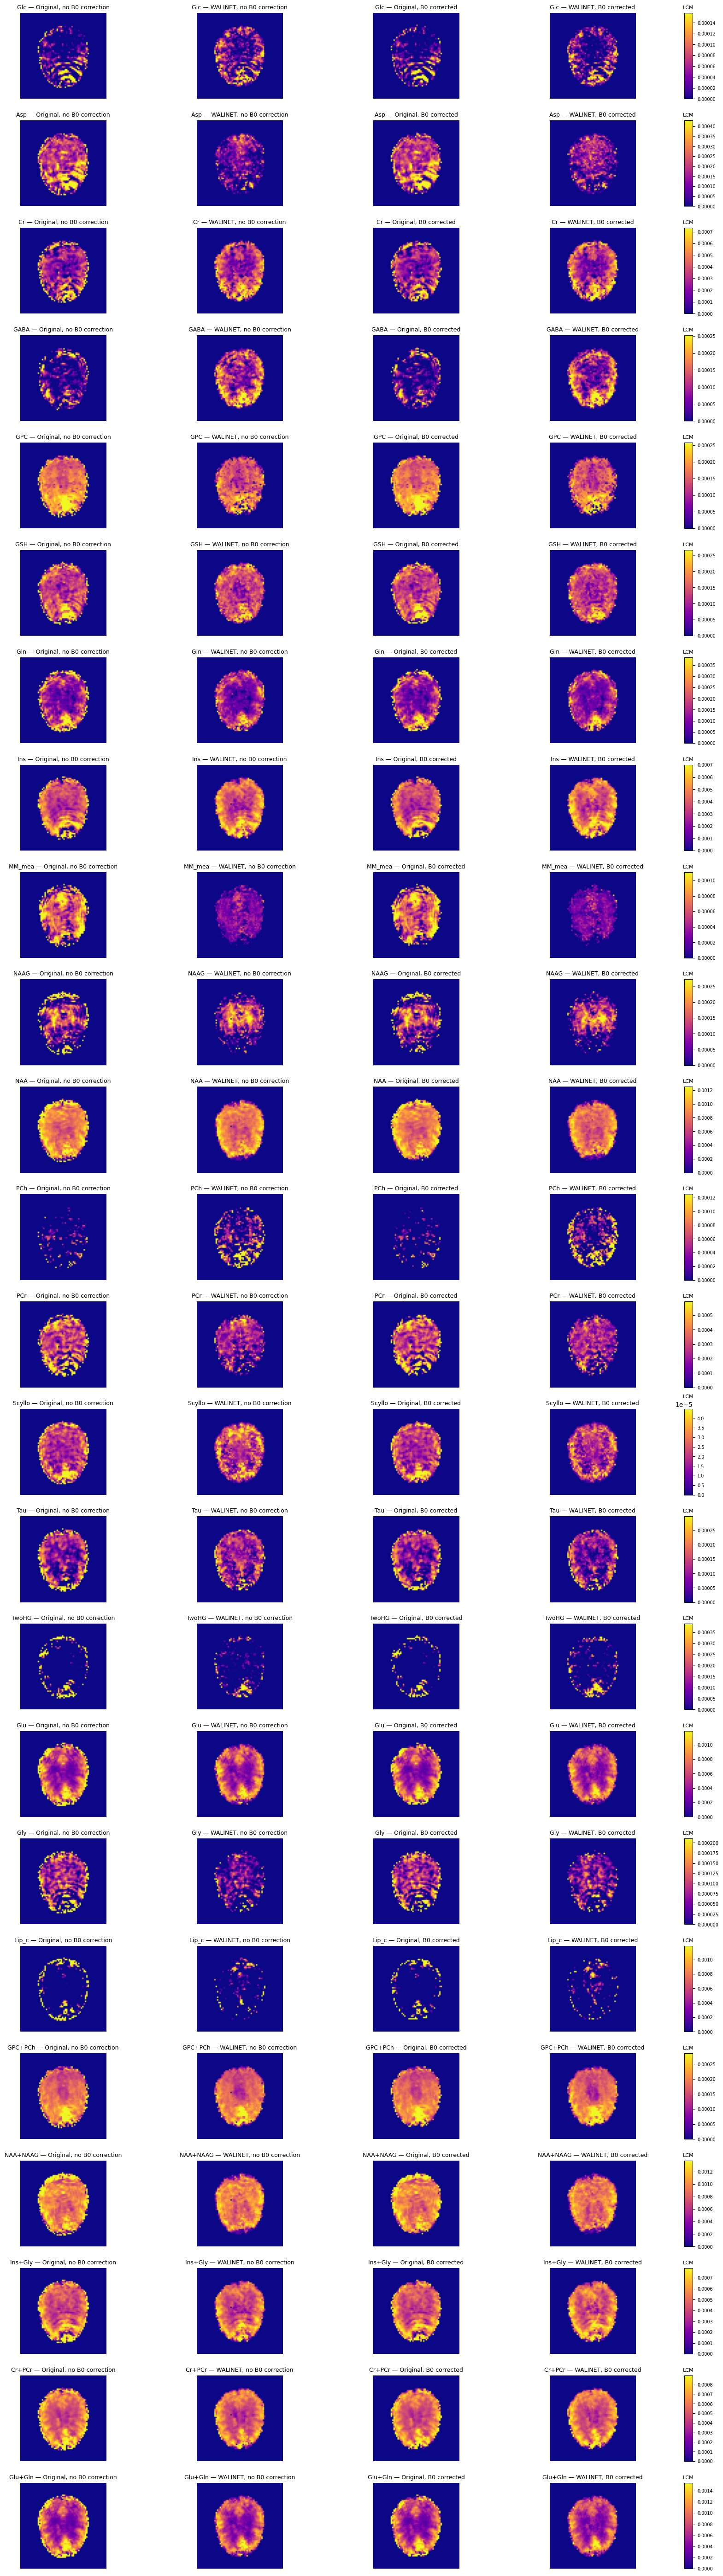

In [1]:
# --- Imports wie gehabt ---
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

# ---------------- Konfiguration ----------------
mat_paths = [
    "../../walinet/notebooks/AllMaps_vanilla_Vol5.mat",
    "../../walinet/notebooks/AllMaps_No_B0_corretion_after_Walinet.mat",
    "../../walinet/notebooks/AllMaps_vanilla_B0_corrected.mat",
    "../../walinet/notebooks/AllMaps_B0_correction_after_Walinet.mat"
]

col_titles = [
    "Original, no B0 correction",
    "WALINET, no B0 correction",
    "Original, B0 corrected",
    "WALINET, B0 corrected",
]

slice_z = 17
low_pct, high_pct = 2, 98
assert len(mat_paths) == len(col_titles)

# ---------------- Loader ----------------
def load_lcmodel_maps(mat_path):
    with h5py.File(mat_path, 'r') as f:
        metabos = f['AllMaps']['Metabos']
        titles = []
        for ref in metabos['Title'][0]:
            dset = f[ref]
            titles.append(dset[:].tobytes().decode('utf-16-le'))
        maps = metabos['Normal'][:]
        return titles, np.asarray(maps)

# ---------------- Dateien laden ----------------
all_titles, all_maps = [], []
for p in mat_paths:
    t, m = load_lcmodel_maps(p)
    all_titles.append(t)
    all_maps.append(m)

base_titles = all_titles[0]
common_titles = [t for t in base_titles if all(t in tt for tt in all_titles[1:])]
def idx_for(titles, subset): return [titles.index(t) for t in subset]
maps_per_col = [m[idx_for(t, common_titles), ...] for t, m in zip(all_titles, all_maps)]

# ---------------- Plot ----------------
n = len(common_titles)
C = len(maps_per_col)

fig = plt.figure(figsize=(20, n * 3))
# jetzt: C Bildspalten + 1 Colorbar-Spalte
gs = gridspec.GridSpec(
    nrows=n, ncols=C+1,
    width_ratios=[1]*C + [0.05],
    wspace=0.05, hspace=0.25
)

for i, title in enumerate(common_titles):
    row_maps = [maps_per_col[c][i, slice_z, :, :] for c in range(C)]

    vals = np.concatenate([m[~np.isnan(m)] for m in row_maps if not np.isnan(m).all()]) \
           if any(not np.isnan(m).all() for m in row_maps) else np.array([0.0, 1.0])
    vmin_row, vmax_row = np.percentile(vals, (low_pct, high_pct))

    ims = []
    for c, (m, lbl) in enumerate(zip(row_maps, col_titles)):
        ax = fig.add_subplot(gs[i, c])
        arr = np.nan_to_num(m, nan=0.0)
        im = ax.imshow(arr, cmap='plasma', origin='lower',
                       vmin=vmin_row, vmax=vmax_row)
        ax.set_title(f"{title} — {lbl}", fontsize=9)
        ax.axis('off')
        ims.append(im)

    # nur eine Colorbar rechts (basierend auf erstem Image im Row)
    cax = fig.add_subplot(gs[i, C])
    cb = fig.colorbar(ims[0], cax=cax)
    cax.set_title("LCM", fontsize=8)
    cax.tick_params(labelsize=7)

plt.tight_layout()
plt.show()
